In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ghibtools as gh
import matplotlib.pyplot as plt
from params import subject_keys, odeurs, blocs, count_trials, eeg_chans, run_keys, subject_keys, session_keys
from compute_power_at_resp import power_at_resp_job
from bibliotheque import get_pos, init_nan_da, get_odor_from_session
import mne

In [2]:
concat = []
for run_key in run_keys:
    participant = run_key.split('_')[0]
    power_at_resp_participant = power_at_resp_job.get(run_key).to_dataframe()
    concat.append(power_at_resp_participant)
power_at_resp = pd.concat(concat).reset_index(drop = True)

/tmp/ipykernel_17944/3805491644.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(power_at_resp.corr(), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)


<AxesSubplot: >

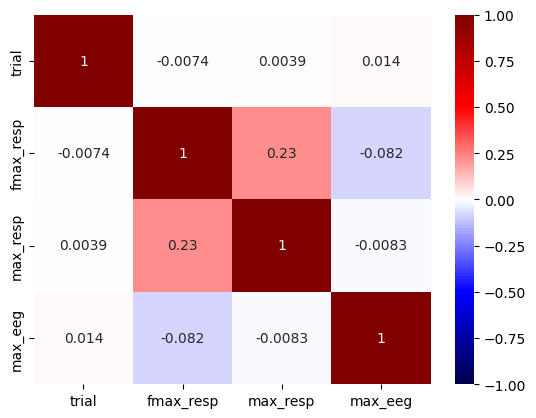

In [3]:
sns.heatmap(power_at_resp.corr(), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)

In [4]:
power_at_resp

,bloc,odor,session,chan,participant,trial,fmax_resp,max_resp,max_eeg
0,Free,odor_-,ses02,Fp1,P01,1,0.24,158.321000,6.776518e-13
1,Free,odor_-,ses02,Fz,P01,1,0.24,158.321000,2.261261e-13
2,Free,odor_-,ses02,F3,P01,1,0.24,158.321000,1.868045e-13
3,Free,odor_-,ses02,F7,P01,1,0.24,158.321000,1.254543e-12
4,Free,odor_-,ses02,FT9,P01,1,0.24,158.321000,1.369577e-12
...,...,...,...,...,...,...,...,...,...
30623,Fast,odor_+,ses04,FC6,P31,3,0.40,4338.387256,2.144711e-11
30624,Fast,odor_+,ses04,FC2,P31,3,0.40,4338.387256,1.654598e-12
30625,Fast,odor_+,ses04,F4,P31,3,0.40,4338.387256,7.202935e-12
30626,Fast,odor_+,ses04,F8,P31,3,0.40,4338.387256,8.982742e-11


<AxesSubplot: xlabel='bloc', ylabel='fmax_resp'>

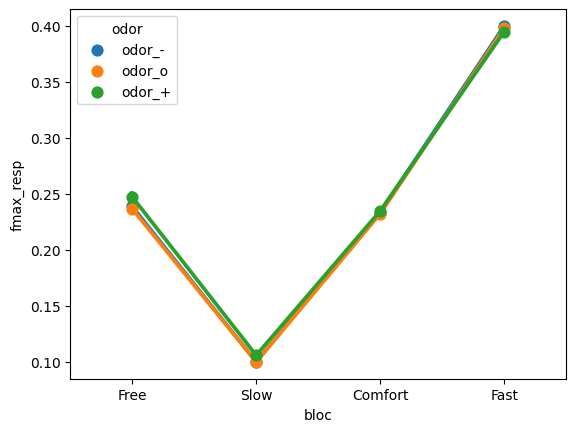

In [5]:
sns.pointplot(data = power_at_resp, x = 'bloc', y = 'fmax_resp', hue = 'odor')

In [6]:
power_at_resp[power_at_resp['chan'] == 'Fp2']

,bloc,odor,session,chan,participant,trial,fmax_resp,max_resp,max_eeg
30,Free,odor_-,ses02,Fp2,P01,1,0.24,158.321000,3.236663e-13
61,Free,odor_-,ses02,Fp2,P01,2,0.28,179.797885,4.583601e-13
92,Slow,odor_-,ses02,Fp2,P01,1,0.10,1511.162463,7.749720e-12
123,Slow,odor_-,ses02,Fp2,P01,2,0.10,2709.431245,5.363288e-11
154,Slow,odor_-,ses02,Fp2,P01,3,0.11,780.496813,2.146960e-11
...,...,...,...,...,...,...,...,...,...
30503,Comfort,odor_+,ses04,Fp2,P31,2,0.12,1329.883601,6.195535e-11
30534,Comfort,odor_+,ses04,Fp2,P31,3,0.12,884.790069,9.757763e-12
30565,Fast,odor_+,ses04,Fp2,P31,1,0.40,6798.685663,3.373460e-12
30596,Fast,odor_+,ses04,Fp2,P31,2,0.40,7266.524603,5.190936e-12


In [8]:
def remove_outliers(df, colname, thresh):
    col = df[colname]
    log_values = np.log(col.values)
    med_log = np.median(log_values)
    mad_log = gh.mad(log_values)
    thresh_low_log = med_log - thresh * mad_log
    thresh_high_log = med_log + thresh * mad_log
    thresh_low = np.exp(thresh_low_log)
    thresh_high = np.exp(thresh_high_log)
    remove = (col < thresh_low) | (col > thresh_high)
    keep = ~remove
    remove_df = df[remove]
    keep_df = df[keep]
    return remove_df, keep_df

In [9]:
power_at_resp_log = power_at_resp.copy()

In [10]:
power_at_resp_log['log_max_eeg'] = np.log(power_at_resp['max_eeg'].values)

In [11]:
power_at_resp_log.head()

,bloc,odor,session,chan,participant,trial,fmax_resp,max_resp,max_eeg,log_max_eeg
0,Free,odor_-,ses02,Fp1,P01,1,0.24,158.321,6.776518e-13,-28.020143
1,Free,odor_-,ses02,Fz,P01,1,0.24,158.321,2.261261e-13,-29.117684
2,Free,odor_-,ses02,F3,P01,1,0.24,158.321,1.868045e-13,-29.308714
3,Free,odor_-,ses02,F7,P01,1,0.24,158.321,1.254543e-12,-27.404249
4,Free,odor_-,ses02,FT9,P01,1,0.24,158.321,1.369577e-12,-27.316519


In [17]:
def plot_topomap(df, colname, delta_quantile):
    
    vmin = np.quantile(df.groupby(['bloc','odor','session','chan']).mean(numeric_only = True)[colname].values, delta_quantile)
    vmax = np.quantile(df.groupby(['bloc','odor','session','chan']).mean(numeric_only = True)[colname].values, 1 - delta_quantile)

    pos = get_pos()
    
    fig, axs = plt.subplots(nrows = len(odeurs), ncols = len(blocs), figsize = (18,8))
    fig.suptitle('EEG Power at respiration frequency', fontsize = 20, y = 1.1)
    for c, bloc in enumerate(blocs):
        for r, odor in enumerate(odeurs) :
            ax = axs[r,c]
            topo_data = df[(df['bloc'] == bloc) & (df['odor'] == odor)].groupby('chan').mean(numeric_only = True)[colname].reindex(eeg_chans)
            # im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos.values, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
            im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
            ax.set_title(f'{bloc} - {odor}')
            
    ax_x_start = 0.9
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    
    if 'log' in colname.split('_'):
        clb.ax.set_title('ln(V**2)',fontsize=15)
    else:
        clb.ax.set_title('V**2',fontsize=15)
    return fig

In [18]:
remove, keep = remove_outliers(power_at_resp_log, 'max_eeg', 2)

In [19]:
remove.shape

(1055, 10)

In [20]:
keep.shape

(29573, 10)

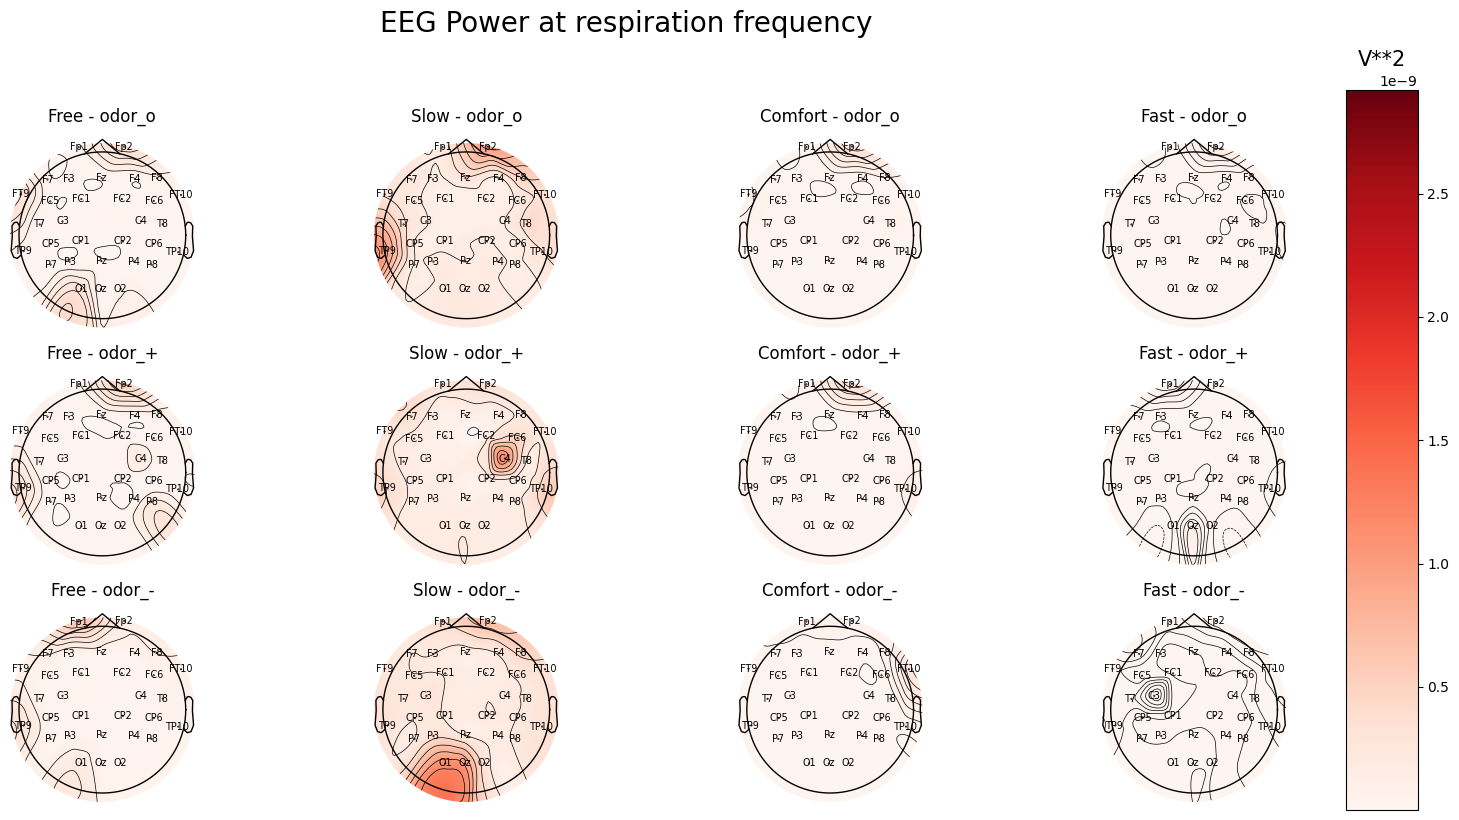

In [21]:
fig1 = plot_topomap(power_at_resp_log, 'max_eeg', 0)

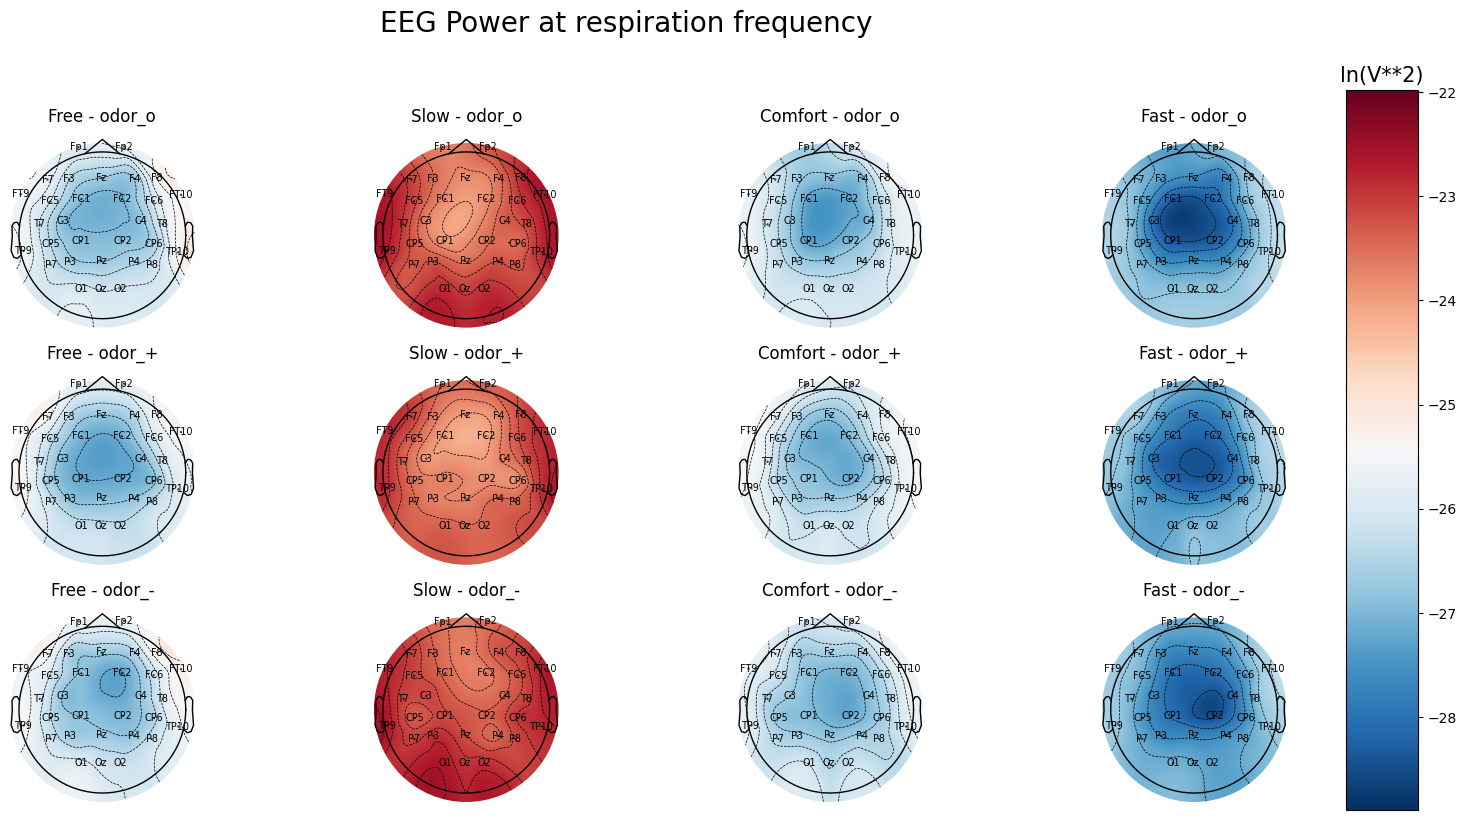

In [22]:
fig2 = plot_topomap(power_at_resp_log, 'log_max_eeg', 0)

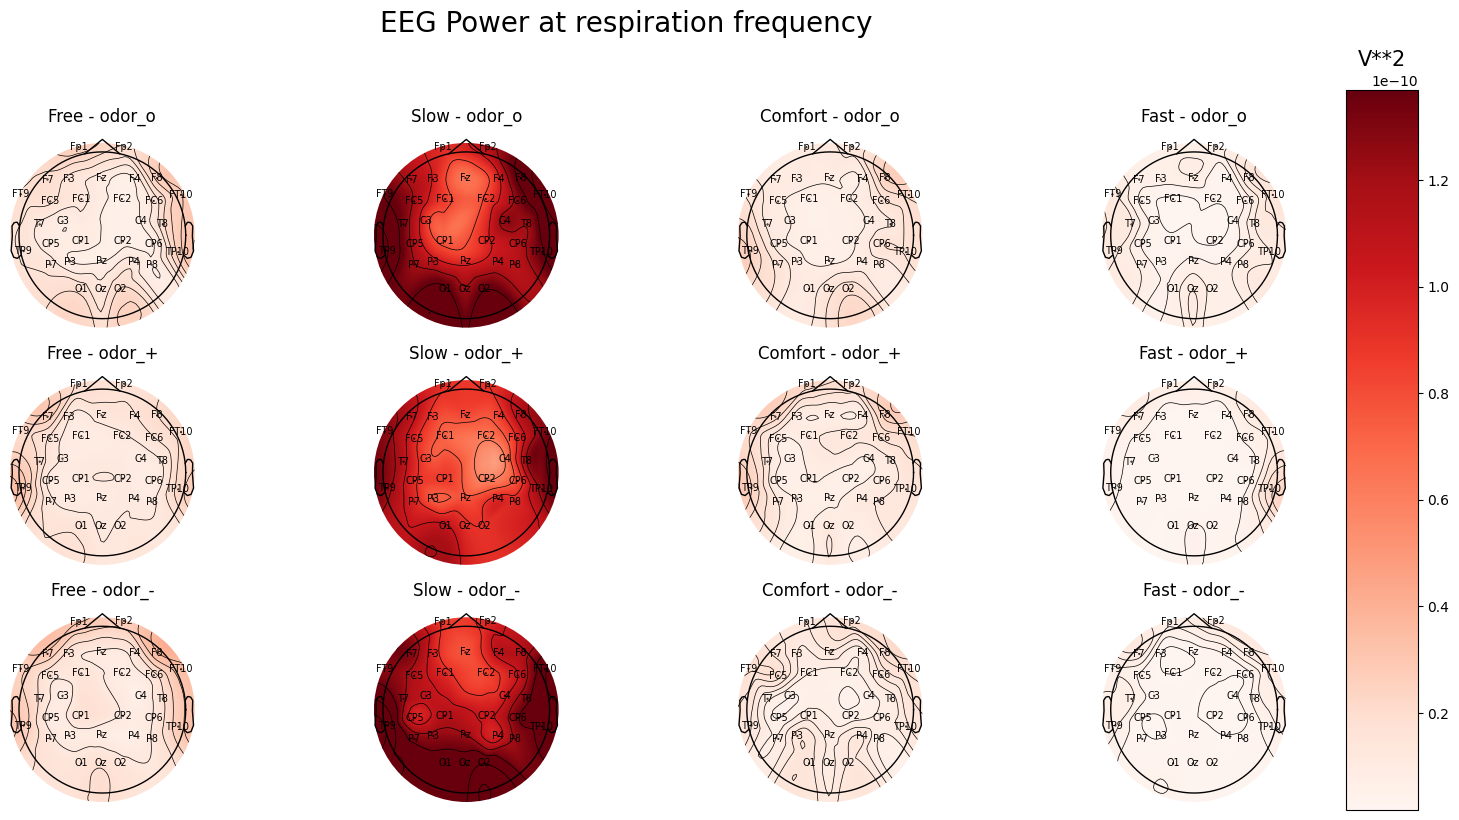

In [23]:
fig3 = plot_topomap(keep, 'max_eeg' , 0.05)

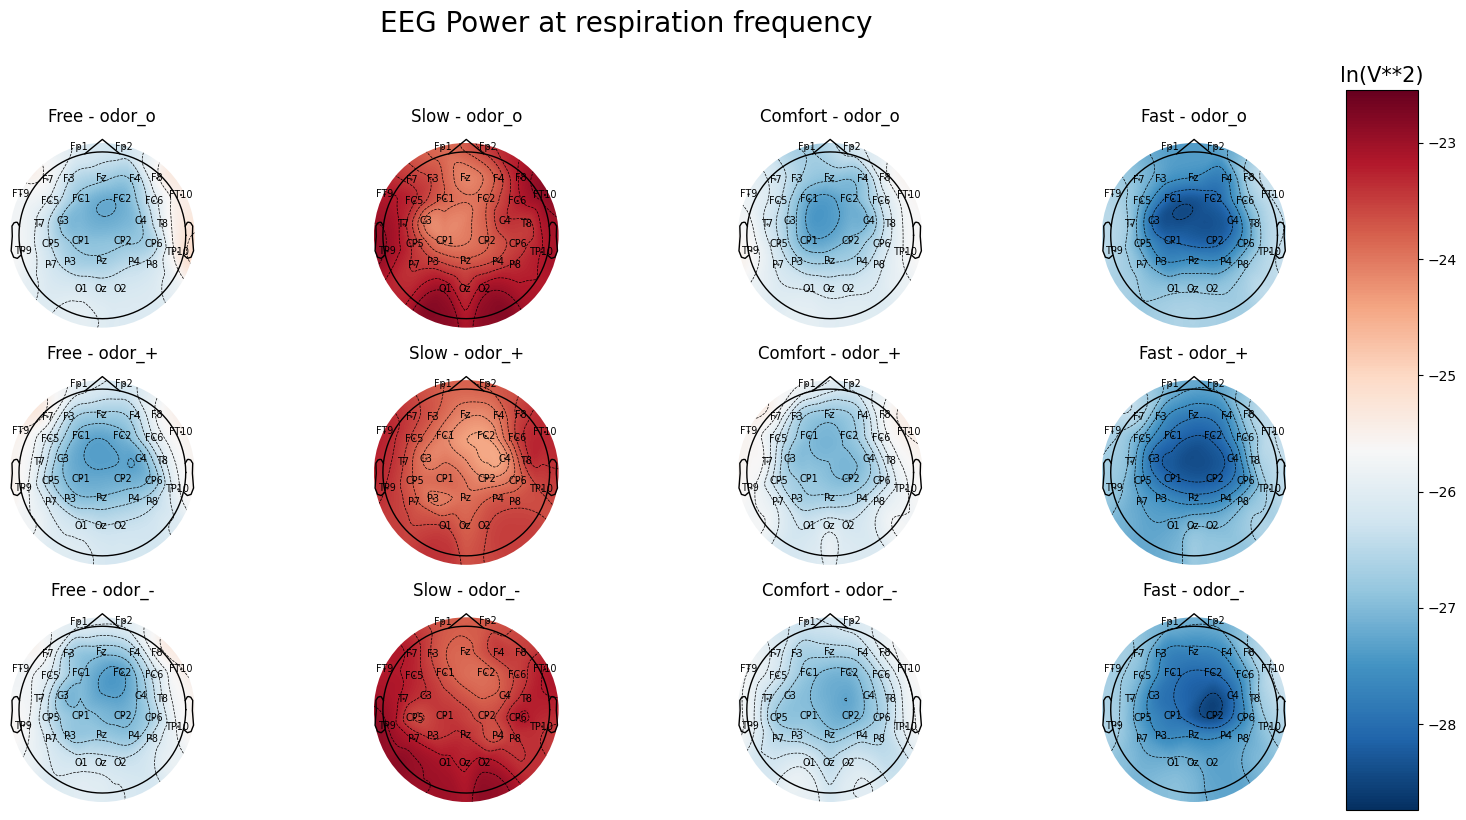

In [24]:
fig4 = plot_topomap(keep, 'log_max_eeg' , 0)

In [27]:
# fig3.savefig('../Figures/Power_at_resp/linear_power_at_resp', bbox_inches = 'tight')
# fig4.savefig('../Figures/Power_at_resp/log_power_at_resp', bbox_inches = 'tight')

In [57]:
def plot_topomap_sub(subject, df, colname, delta_quantile):
    
    df = df[df['participant'] == subject]
    
    vmin = np.quantile(df.groupby(['bloc','odor','session','chan']).mean(numeric_only = True)[colname].values, delta_quantile)
    vmax = np.quantile(df.groupby(['bloc','odor','session','chan']).mean(numeric_only = True)[colname].values, 1 - delta_quantile)
    
    pos = get_pos()
    
    fig, axs = plt.subplots(nrows = len(odeurs), ncols = len(blocs), figsize = (18,8))
    fig.suptitle(f'EEG Power at respiration frequency - {subject}', fontsize = 20, y = 1.1)
    for c, bloc in enumerate(blocs):
        for r, odor in enumerate(odeurs) :
            ax = axs[r,c]
            topo_data = df[(df['bloc'] == bloc) & (df['odor'] == odor)].groupby('chan').mean(numeric_only = True)[colname].reindex(eeg_chans)
            # im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos.values, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
            im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
            ax.set_title(f'{bloc} - {odor}')
            
    ax_x_start = 0.9
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    
    if 'log' in colname.split('_'):
        clb.ax.set_title('ln(V**2)',fontsize=15)
    else:
        clb.ax.set_title('V**2',fontsize=15)
    return fig

In [59]:
for sub in subject_keys:
    fig = plot_topomap_sub(sub, power_at_resp_log, 'log_max_eeg', 0)
    fig.savefig(f'../Figures/Power_at_resp/by_subject/{sub}', bbox_inches = 'tight')
    plt.close()

In [ ]:
# from psd import psd_eeg_job
# da_all = None
# sessions = session_keys
# participants = subject_keys
# for run_key in run_keys:
    
#     ds = psd_eeg_job.get(run_key)
#     da = ds['psd']
    
#     participant, session = run_key.split('_')[0], run_key.split('_')[1]
#     odor = get_odor_from_session(run_key)

#     if da_all is None:
#         da_all = init_nan_da({'participant':participants, 'odor':odeurs, 'bloc':da.coords['bloc'].values, 'trial':da.coords['trial'].values, 'chan':da.coords['chan'].values, 'freq':da.coords['freq'].values})
        
#     da_all.loc[participant, odor, : ,: ,:,:] = da.values